In [1]:
# Import all the needed libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
"""Prepare the dataset"""
df = pd.read_csv('dataset.csv')
print(df['Label'].unique())

# Prompt for input. If y -> remove numbers.
remove_num = input()
if remove_num == 'y':
    df['Text'] = df['Text'].str.replace("[0-9]", "", regex = True)

# Clean the data -> Remove special characters and drop empty rows
df['Text'] = df['Text'].str.replace("[^a-zA-Z0-9 ]", " ", regex = True)
df['Text'] = df['Text'].str.lower()
df = df.drop(df[df['Text'] == ''].index)
df = df.dropna().reset_index(drop=True)

# Interested in only english text and neg/pos 
df = df[df['Language'] == 'en']
df_pos = df[df['Label'] == 'positive']
df_neg = df[df['Label'] == 'negative']
df = pd.concat([df_pos, df_neg]).sample(frac = 1).reset_index(drop=True)

# split the dataframe into train set, test set, and validation set
df_train = df.sample(frac = 0.8).reset_index(drop=True)
df_testnval = df.drop(df_train.index).sample(frac=1).reset_index(drop=True)
df_test = df_testnval.sample(frac = 0.5).reset_index(drop=True)
df_val = df_testnval.drop(df_test.index).sample(frac=1).reset_index(drop=True)

# Change the format of those sets from df to np
np_train_txt = df_train['Text'].to_numpy()
np_train_label = df_train['Label'].to_numpy()
np_test_txt = df_test['Text'].to_numpy()
np_test_label = df_test['Label'].to_numpy()
np_val_txt = df_val['Text'].to_numpy()
np_val_label = df_val['Label'].to_numpy()

def label_to_int(np_label, np_length):
    label_int = []
    for i in range(np_length):
        if np_label[i] == 'negative':
            label_int.append(0)
        else:
            label_int.append(1)
    return np.asarray(label_int)

np_train_label_int = label_to_int(np_train_label, len(df_train['Label']))
np_test_label_int = label_to_int(np_test_label, len(df_test['Label']))
np_val_label_int = label_to_int(np_val_label, len(df_val['Label']))

print(len(df_pos))
print(len(df_neg))
print(df_train)
print(np_train_txt)
print(np_train_label)
print(np_train_label_int)

['litigious' 'negative' 'positive' 'uncertainty']
y
248516
244146
                                                     Text Language     Label
0       i ll just keep waiting for something to improv...       en  positive
1                               winxmyg but it looks good       en  positive
2        boococp  dr d robertson  let the bodies pile ...       en  positive
3       improve your content marketing program with sl...       en  positive
4                               picsarhx  this is perfect       en  positive
...                                                   ...      ...       ...
394125  i m so tired and hungry and hot and our dad is...       en  negative
394126   brett porter  kristynwongtam i d like to hope...       en  negative
394127   colander  sweeney archive poor robert  he was...       en  negative
394128  studies have shown that regular yoga practice ...       en  positive
394129   staticxml  cric analytics  ajarrodkimber i m ...       en  negative

[394130 r

In [3]:
"""Prepare pre-trained word embedding"""
# Write the text file into dictionary
embed_dict = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        wordnvecs = line.split()
        word = wordnvecs[0]
        vec = np.asarray(wordnvecs[1:], "float32")
        embed_dict[word] = vec

In [4]:
"""Word embedding layer"""
# Find the 95th percentile word length
def per95(df_train):
    txt_lengths = []
    for index, row in df_train.iterrows():
        txt_lengths.append(len(row[0].split()))
    length = np.percentile(np.asarray(txt_lengths), 95)
    return(length)
print(per95(df_train))
print(df_train)

# Create vocab index
length = int(per95(df_train))
vectorizer = layers.TextVectorization(max_tokens=10000, output_sequence_length=int(per95(df_train)))
vectorizer.adapt(np_train_txt)
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

# Create word embedding matrix. For unknown and padding, the value is 0 
n_tokens = len(vocab) + 2
vec_dim = 100
embedding_matrix = np.zeros((len(vocab) + 2, vec_dim))
for word, i in word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# Take the embedding matrix into the embedding layer of the neural network
embedding_layer = layers.Embedding(
    n_tokens,
    vec_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

54.0
                                                     Text Language     Label
0       i ll just keep waiting for something to improv...       en  positive
1                               winxmyg but it looks good       en  positive
2        boococp  dr d robertson  let the bodies pile ...       en  positive
3       improve your content marketing program with sl...       en  positive
4                               picsarhx  this is perfect       en  positive
...                                                   ...      ...       ...
394125  i m so tired and hungry and hot and our dad is...       en  negative
394126   brett porter  kristynwongtam i d like to hope...       en  negative
394127   colander  sweeney archive poor robert  he was...       en  negative
394128  studies have shown that regular yoga practice ...       en  positive
394129   staticxml  cric analytics  ajarrodkimber i m ...       en  negative

[394130 rows x 3 columns]


In [5]:
# Build the 1D CNN model
int_sequences_input = tf.keras.Input(shape=(None, ), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
model_layers = layers.Conv1D(128, 5, padding="same", activation="relu")(embedded_sequences)
model_layers = layers.MaxPooling1D(2)(model_layers)
model_layers = layers.Conv1D(128, 5, padding="same", activation="relu")(model_layers)
model_layers = layers.MaxPooling1D(2)(model_layers)
model_layers = layers.Conv1D(128, 5, padding="same", activation="relu")(model_layers)
model_layers = layers.GlobalMaxPooling1D()(model_layers)
model_layers = layers.Dense(64, activation="relu")(model_layers)
model_layers = layers.Dropout(0.5)(model_layers)
model_layers = layers.Dense(1, activation="sigmoid")(model_layers)
model = tf.keras.Model(int_sequences_input, model_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [6]:
"""Train the model"""
x_train = vectorizer(np_train_txt).numpy()
x_val = vectorizer(np_val_txt).numpy()
y_train = np_train_label_int
y_val = np_val_label_int

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=256, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
1540/1540 [==============================] - 33s 8ms/step - loss: 0.0716 - accuracy: 0.9726 - val_loss: 0.0243 - val_accuracy: 0.9907
Epoch 2/30
1540/1540 [==============================] - 12s 8ms/step - loss: 0.0287 - accuracy: 0.9902 - val_loss: 0.0213 - val_accuracy: 0.9924
Epoch 3/30
1540/1540 [==============================] - 12s 8ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.0213 - val_accuracy: 0.9914
Epoch 4/30
1540/1540 [==============================] - 11s 7ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0188 - val_accuracy: 0.9929
Epoch 5/30
1540/1540 [==============================] - 11s 7ms/step - loss: 0.0220 - accuracy: 0.9922 - val_loss: 0.0186 - val_accuracy: 0.9934
Epoch 6/30
1540/1540 [==============================] - 11s 7ms/step - loss: 0.0204 - accuracy: 0.9927 - val_loss: 0.0183 - val_accuracy: 0.9934
Epoch 7/30
1540/1540 [==============================] - 11s 7ms/step - loss: 0.0187 - accuracy: 0.9931 - val_loss: 0.0191 - val_ac

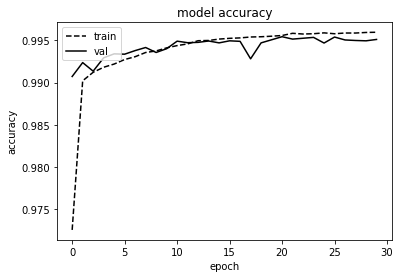

In [7]:
"""Plot the validation graph"""
plt.plot(history.history['accuracy'], 'k--')
plt.plot(history.history['val_accuracy'], 'k')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
x_test = vectorizer(np_test_txt).numpy()
y_test = np_test_label_int
pos = 0
neg = 0
for label in df['Label']:
    if label == 'positive':
        pos += 1
    else:
        neg += 1
print("pos:neg = ", pos/neg)
print("Evaluate the model using test data")
results = model.evaluate(x_test, y_test, batch_size=256)
print("test loss, test acc:", results)

pos:neg =  1.0178991259328434
Evaluate the model using test data
193/193 [==============================] - 1s 3ms/step - loss: 0.0223 - accuracy: 0.9953
test loss, test acc: [0.02231927588582039, 0.9952705502510071]
